<a href="https://colab.research.google.com/github/gianguyen7/LightGCN-Ensemble-Learning/blob/main/Implementation_Platform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Dictionary
'''
reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
asin - ID of the product, e.g. 0000013714
reviewerName - name of the reviewer
helpful - helpfulness rating of the review, e.g. 2/3
reviewText - text of the review
overall - rating of the product
summary - summary of the review
unixReviewTime - time of the review (unix time)
reviewTime - time of the review (raw)
'''

'\nreviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B\nasin - ID of the product, e.g. 0000013714\nreviewerName - name of the reviewer\nhelpful - helpfulness rating of the review, e.g. 2/3\nreviewText - text of the review\noverall - rating of the product\nsummary - summary of the review\nunixReviewTime - time of the review (unix time)\nreviewTime - time of the review (raw)\n'

In [ ]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# %matplotlib inline
plt.style.use("ggplot")

import sklearn
from sklearn.decomposition import TruncatedSVD

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Read in the Data
data = pd.read_csv("/content/gdrive/My Drive/DS 340W/musical_instruments.csv")
data.head(5)

,reviewerID,asin,reviewerName,helpful/0,helpful/1,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...",0,0,"Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,13,14,The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""",1,1,The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""",0,0,Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,0,0,This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [ ]:
#Checking for NA values
data.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful/0          0
helpful/1          0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [ ]:
#Dropping all rows with NA
data = data.dropna()

In [ ]:
data.shape

(10227, 10)

In [ ]:
#Defining popular instruments in the dataset
popular_products = pd.DataFrame(data.groupby('asin')['overall'].count())
most_popular = popular_products.sort_values('overall', ascending=False)
most_popular.head(10)

,overall
asin,
B003VWJ2K8,163
B0002E1G5C,143
B0002F7K7Y,116
B003VWKPHC,114
B0002H0A3S,93
B0002CZVXM,74
B0006NDF8A,71
B0009G1E0K,69
B0002E2KPC,68


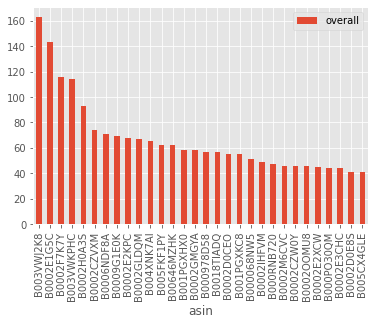

In [ ]:
#Plotting most popular instruments
most_popular.head(30).plot(kind = "bar")

EDA

In [ ]:
ratingCount =  data.groupby(['overall'])
ratingCount = ratingCount['overall'].count()
ratingCount = ratingCount.nlargest(10, 'first')
ratingCount = px.bar(ratingCount, x = 'overall', title = 'Top Rating Counts', width = 800, height = 800)
ratingCount.update_layout(yaxis_title = "overall", xaxis_title = "count")
ratingCount.show()

**Implementation**

In [ ]:
pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 6.3 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633966 sha256=5ef930b3d93ed9584cf01d22da9d68e1a33070f68da5d2657ce70df0ba34b726
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import KFold

reader = Reader()
data = Dataset.load_from_df(data[['reviewerID', 'asin', 'overall']], reader)
svd = SVD()

In [ ]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=5, threshold=4.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [ ]:
kf = KFold(n_splits=5)
algo = SVD()

In [ ]:
i =1
for trainset, testset in kf.split(data):
      algo.fit(trainset)
      predictions = algo.test(testset)
      precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=5)
      
      # Precision and recall can then be averaged over all users
      print("The precision for kf = {}: ".format(i))
      print(sum(prec for prec in precisions.values()) / len(precisions))
      print("The recall for kf = {}: ".format(i))
      print(sum(rec for rec in recalls.values()) / len(recalls))
      i+=1

The precision for kf = 1: 
0.011580381471389645
The recall for kf = 1: 
0.006222697980191167
The precision for kf = 2: 
0.030436802973977696
The recall for kf = 2: 
0.01850475010326311
The precision for kf = 3: 
0.020398912058023574
The recall for kf = 3: 
0.010108794197642794
The precision for kf = 4: 
0.023415977961432508
The recall for kf = 4: 
0.013552983594305908
The precision for kf = 5: 
0.015610651974288337
The recall for kf = 5: 
0.009956709956709955


In [ ]:
# Run 5-fold cross-validation and print results
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9018  0.8402  0.8453  0.8892  0.8936  0.8740  0.0259  
MAE (testset)     0.6471  0.6237  0.6249  0.6389  0.6419  0.6353  0.0094  
Fit time          0.52    0.52    0.50    0.50    0.49    0.51    0.01    
Test time         0.01    0.01    0.01    0.02    0.01    0.02    0.00    


{'test_rmse': array([0.9018277 , 0.840167  , 0.84533965, 0.88920752, 0.89360193]),
 'test_mae': array([0.64707752, 0.62367142, 0.62488563, 0.63894154, 0.64190106]),
 'fit_time': (0.5195474624633789,
  0.5247399806976318,
  0.4967074394226074,
  0.5036108493804932,
  0.49074864387512207),
 'test_time': (0.014055728912353516,
  0.01477956771850586,
  0.014155149459838867,
  0.02125692367553711,
  0.014180183410644531)}